In [171]:
import numpy as np
import pandas as pd
import gpstk
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', np.RankWarning)
%matplotlib inline

# Get stations baseline < 100 Km

In [172]:
data=pd.read_csv("conus_2003_324_324.csv")
data.columns=["Station", "a","b","c","x","y","z"]

In [173]:
data=data.drop(["a","b","c"],axis=1)
array=data.as_matrix()

In [174]:
def get_pairs(array):
    distances=[]
    for i in range(len(array)):
        for j in range(i+1,len(array)):
            distance=np.sqrt((array[i][1]-array[j][1])**2+(array[i][2]-array[j][2])**2+(array[i][3]-array[j][3])**2)
            if distance<100e3:
                distances.append([array[i][0],array[j][0]])
    return distances

In [175]:
pairs=get_pairs(array)
print "Number of Stations with baseline less than 100 Km ",len(pairs)
pairs[:10]

Number of Stations with baseline less than 100 Km  455


[['1ulm', 'sihs'],
 ['1ulm', 'wnfl'],
 ['abq1', 'nmsf'],
 ['abq1', 'zab1'],
 ['acu1', 'npri'],
 ['adks', 'ang1'],
 ['adks', 'ang2'],
 ['adks', 'lkhu'],
 ['adks', 'netp'],
 ['adks', 'txhu']]

In [176]:
stations=[item for sublist in pairs for item in sublist]
stations=list(np.unique(stations))
print len(stations)
#print stations

302


## Functions

In [177]:
def adjust_times(df):
    df=df.sort("TIME")
    times=df.TIME.as_matrix()
    for i in range(times.size):
        if times[i]%30!=0:
            times[i]=times[i]+(30-times[i]%30)
    df["TIME"]=times
    return df

In [178]:
def label_arcs(df):
    time=df.TIME.as_matrix()
    diff=np.diff(time)>3600
    diff=np.hstack((np.array([False]),diff))
    split=np.where(diff==True) #points where there is a "True" value
    
    if len(split[0])>0:
        arcs=np.split(time,split[0])
        arcsID=[]
        n=1
        for i in range(len(arcs)):
            size=len(arcs[i])
            tmp=np.empty(size)
            tmp[:]=n
            arcsID.append(tmp)
            n+=1
        arcsID=np.concatenate(arcsID)
    else:#one arc
        arcsID=np.empty(time.size)
        arcsID[:]=1
        
    df["ARCS"]=arcsID
    return df

In [179]:
def cycle_slips(PhaseDelay,L1,L2,threshold=0.5):
    slips=[]
    slips=np.where(np.abs(np.diff(np.hstack(([0],PhaseDelay))))>threshold) 
    #noL1=np.where(L1==np.nan)[0] #is nan?
    #noL2=np.where(L2==np.nan)[0]
    #print "Slips",slips
    noL1=np.where(np.isnan(L1)==True)[0]#is nan?
    noL2=np.where(np.isnan(L2)==True)[0]
    if len(noL1)>0:
        print "No L1", noL1
    if len(noL2)>0:
        print "No L2", noL2
    
    return slips[0]
    

In [180]:
def subarcs(arc,dfarc,splits):
    time=dfarc.TIME
    if len(splits)>0:
        subarcs=np.split(time,splits)
        subarcsID=[]
        n=arc*10
        for i in range(len(subarcs)):
            size=len(subarcs[i])
            tmp=np.empty(size)
            tmp[:]=n
            subarcsID.append(tmp)
            n+=1
        subarcsID=np.concatenate(subarcsID)
    else:#one arc
        subarcsID=np.empty(time.size)
        subarcsID[:]=arc*10+1
    dfarc["SUBARCS"]=subarcsID
    return dfarc

In [181]:
def del_arcs(df): #delete arcs with less than 10 point
    subarcs=df.SUBARCS.values
    for subarc in np.unique(subarcs):
        if len(np.where(df.SUBARCS==subarc)[0])<10:#.SUBARCS
            #print "Subarc id",subarc," deleted with ",len(np.where(df.SUBARCS==subarc)[0])," datapoints"
            del_points =np.where(df.SUBARCS==subarc)[0] #Save times so we can delete in other station
            df=df[df.SUBARCS!=subarc]    
    return df
            

In [182]:
def poly_fit(dfarc):
    #receives a dataframe with a number of subarcs
    #On each subarc takes N elements from LI=L1-L2 and performs interpolation, 
    f1,f2=gpstk.L1_FREQ_GPS,gpstk.L2_FREQ_GPS
    alfa=1.0/((f1**2/f2**2)-1)
    #Lists potential outliers and time when it occurs on each subarc
    times,gradients=[],[]
    subarcs=np.unique(dfarc.SUBARCS.values)
    for subarc in subarcs:
        dfsubarc=dfarc[dfarc.SUBARCS==subarc]
        N=10 #window 
        tPoly ,Poly=[],[]
        lI=alfa*(dfsubarc.L1.as_matrix()-dfsubarc.L2.as_matrix())
        time=dfsubarc.TIME.as_matrix()

        for i in range(0,lI.size,N): 
            x=np.array(time[i:i+N])
            y=np.array(lI[i:i+N])
            z= np.polyfit(x,y,2)
            p = np.poly1d(z)
            for i in range(x.size):
                Poly.append(p(x[i]))
                tPoly.append(x[i]) 
                
        Poly=np.array(Poly)
        
        #detects datajumps in the diference between the polinomyal fit and real data 
        residual=lI-Poly
        candidates=np.where(np.abs(np.diff(np.hstack(([0],residual))))>0.8)[0]

        if len(candidates)>0:
            time_candidates=time[candidates]
            gradient_candidates=residual[candidates]
            times.append(time_candidates) #array candidatos en subarcos
            gradients.append(gradient_candidates)
        else:
            times.append(np.array([]))
            gradients.append(np.array([]))
    
        dfarc.POLYFIT[dfarc.SUBARCS==subarc]=Poly

    return dfarc,times,gradients #df con columna de interpolacion,  array de arrays(algunos vacios), array dde arrays o None (uno por cada sub arco)

In [183]:
def outlier_detect(dfarc,k=10):#k=30? 15 min
    f1,f2=gpstk.L1_FREQ_GPS,gpstk.L2_FREQ_GPS
    alfa=1.0/((f1**2/f2**2)-1)
    #lists outlier factors on each arc
    outliers_subarcs,times_subarcs=[],[]
    subarcs=np.unique(dfarc.SUBARCS.values)
    for subarc in subarcs:
        dfsubarc=dfarc[dfarc.SUBARCS==subarc]
        lI=alfa*(dfsubarc.L1.as_matrix()-dfsubarc.L2.as_matrix())
        times=dfsubarc.TIME.as_matrix()
        times_subarcs.append(times)
        outliers=[] #set of outlier factors for every element in L=L1-L2
    
        for i in range(0,lI.size):
            if i<(k/2+1):
                neighbours=np.hstack((lI[0:i],lI[i+1:i+(k/2)+1])) #neighbours around i, without i
                tn=np.hstack((times[0:i],times[i+1:i+(k/2)+1]))

            elif i>lI.size-(k/2+1):
                neighbours=np.hstack((lI[i-k/2:i],lI[i+1:lI.size+1]))
                tn=np.hstack((times[i-k/2:i],times[i+1:lI.size+1])) #times neighbour

            else:
                neighbours=np.hstack((lI[i-k/2:i],lI[i+1:i+(k/2)+1]))
                tn=np.hstack((times[i-k/2:i],times[i+1:i+(k/2)+1]))

            OFt=0
            deno=np.sum(1/(np.abs(times[i]-tn)*1.0))#denominator de Wpq para elemento i
            for neighbour in range(neighbours.size): 
                if times[neighbour]!=times[i]:
                    Wpq=1/np.abs(times[i]-times[neighbour])
                    Wpq=Wpq/deno
                    OFt+=(Wpq*np.abs(lI[i]-lI[neighbour]))
            outliers.append(OFt)  #outliers in the subarc
        outliers_subarcs.append(outliers) #outliers on arc 

    return outliers_subarcs,times_subarcs #list of lists(suarcs),list of arrays


In [184]:
def remove_outliers(ptimes,otimes,poly_outliers,outliers_factor,subarcs):
    confirmed=[] #times of confirmed outliers
    #print "# Subarcs: ",subarcs
    for subarc in range(subarcs):
        if len(poly_outliers[subarc])>0:
            for i in range(len(poly_outliers[subarc])):
                #print "Quedan", len(poly_outliers[subarc])," candidatos" 
                #check for max outliers with polinomial method
                maxpoly=np.argmax(poly_outliers[subarc])
                valuemaxpoly=poly_outliers[subarc][maxpoly] 
                tmaxpoly=ptimes[subarc][maxpoly]
                #check for max outliers with outliers factor method
                maxofactor=np.argmax(outliers_factor[subarc])
                valuemaxout=outliers_factor[subarc][maxofactor]
                tmaxofactor=otimes[subarc][maxofactor]

                if tmaxofactor==tmaxpoly:
                    if tmaxofactor not in confirmed:
                        confirmed.append(tmaxofactor)
                        #print "Outlier detectado en t=",tmaxofactor
                        #Save time of confirmed outlier
                        #print "Verificar que elemento se elimina"
                        #print len(outliers_factor[subarc])
                        #print len(otimes[subarc])
                        #print poly_outliers[subarc].shape
                        #print ptimes[subarc].shape
                        #Delete point from both methods and continue 
                        outliers_factor[subarc]=np.delete(outliers_factor[subarc],maxofactor)
                        otimes[subarc]=np.delete(otimes[subarc],maxofactor)
                        poly_outliers[subarc]=np.delete(poly_outliers[subarc],maxpoly)
                        ptimes[subarc]=np.delete(ptimes[subarc],maxpoly)
                        #print len(outliers_factor[subarc])
                        #print len(otimes[subarc])
                        #print poly_outliers[subarc].shape
                        #print ptimes[subarc].shape
                    else:
                        #print "Ya estaba confirmado"
                        break
                        

                else: #If there aret any more coincidences stop searching
                    #print "No hay mas confirmados"
                    break

        else:
            #See next subarc
            #print "No hay candidatos con metodo polinomial fit"
            continue
            
    return confirmed

In [185]:
def Hatch_Filter(dfarc): #Code smoothed with Phase measurement
    subarcs=np.unique(dfarc.SUBARCS.values)
    for subarc in subarcs:
        dfsubarc=dfarc[dfarc.SUBARCS==subarc]
        R1=dfsubarc.C1.as_matrix()
        R2=dfsubarc.C2.as_matrix()
        L1=dfsubarc.L1.as_matrix()
        L2=dfsubarc.L2.as_matrix()
    
        size=len(R1)#R.size
        N=10 
        
        for k in range(1,size):
            if k>N:
                n=N
            else:
                n=k
            R1[k]=(R1[k]/n)+((n-1.0)/n)*(R1[k-1]+(L1[k]-L1[k-1]))
            R2[k]=(R2[k]/n)+((n-1.0)/n)*(R2[k-1]+(L2[k]-L2[k-1]))
            
        dfarc.HATCHCODE1[dfarc.SUBARCS==subarc]=R1
        dfarc.HATCHCODE2[dfarc.SUBARCS==subarc]=R2
    return dfarc
    

In [186]:
def Level_Arc(dfarc):
    dfarc.Elevation
    f1,f2=gpstk.L1_FREQ_GPS,gpstk.L2_FREQ_GPS
    alfa=1.0/((f1**2/f2**2)-1)
    subarcs=np.unique(dfarc.SUBARCS.values)
    for subarc in subarcs:
        dfsubarc=dfarc[dfarc.SUBARCS==subarc]
        dfsubarc.CodeDelay=alfa*(dfsubarc.HATCHCODE2-dfsubarc.HATCHCODE2)
        dfsubarc.PhaseDelay=alfa*(dfsubarc.L1-dfsubarc.L2)
        L=np.sum((dfsubarc.CodeDelay-dfsubarc.PhaseDelay)*(np.sin(dfsubarc.Elevation)**2))/np.sum(np.sin(dfsubarc.Elevation)**2) #leveling factor
        dfsubarc.PhaseDelay=dfsubarc.PhaseDelay+L
        dfarc.PhaseDelay[dfarc.SUBARCS==subarc]=dfsubarc.PhaseDelay
    
    return dfarc
        
    

# Preprocessing each station


In [187]:
from os import listdir
dir_txt="txtcors/"
files = [f for f in listdir(dir_txt)]

f1=gpstk.L1_FREQ_GPS
f2=gpstk.L2_FREQ_GPS
factor_alfa=f2**2/(f1**2-f2**2)
c=3e8
alfa=1.0/((f1**2/f2**2)-1) 

for station in stations[1:2]:
    #Load Files]
    columns=["PRN","TIME","C1","C2","L1","L2","Tgd","IPP","Elevation","Azimuth"]
    txtfile=dir_txt+[f for f in files if station in f ][0]
    newdf=pd.DataFrame()
    df=pd.read_csv(txtfile,sep=",")
    df.columns=columns
    sats=np.unique(df.PRN.values)
    #print sats
    #For each satellite observed by the station
    for sat in sats :
        df1sat=df[df.PRN==sat] #dataframe with times of an specific satellite
        df1=df.reset_index(drop=True)
        #Estimate delay measures 
        df1sat["PhaseDelay"]=alfa*(df1sat.L1-df1sat.L2)
        df1sat["CodeDelay"]=alfa*(df1sat.C2-df1sat.C1)
        #Add column with indicators of time separation (ARC)
        df1sat=label_arcs(df1sat)
        ARCS=np.unique(df1sat.ARCS.values)
        for arc in ARCS:
            #Search for cycle Slips on each arc
            dfarc=df1sat[df1sat.ARCS==arc]
            slips=cycle_slips(dfarc.PhaseDelay.as_matrix(),dfarc.L1.as_matrix(),dfarc.L2.as_matrix(),2.5)
            #Use slips to divide one contnuous arc in sub arcs
            dfarc=subarcs(arc,dfarc,slips)
            #Remove short-arcs 
            dfarc=del_arcs(dfarc)
            #Outliers Detection and Removal
            ##Polinomial fit Method
            dfarc["POLYFIT"]=np.nan
            dfarc,ptimes,poly_outliers=poly_fit(dfarc)
            ##Outliers Factor Method
            outliersfactors,otimes=outlier_detect(dfarc,10)
            nsubarcs=len(np.unique(dfarc.SUBARCS.values)) #number of subarcs
            deltimes=remove_outliers(ptimes,otimes,poly_outliers,outliersfactors,nsubarcs)
            if len(deltimes)>0:
                print "Outliers detected in station "+ station+", : ",len(deltimes)
                for t in deltimes:
                    dfarc=dfarc[dfarc.TIME!=t]
            #Hatch filter 
            dfarc["HATCHCODE1"]=np.nan
            dfarc["HATCHCODE2"]=np.nan
            dfarc=Hatch_Filter(dfarc)
            #Phase leveling 
            dfarc=Level_Arc(dfarc)
            #Save in newdf
            con=[newdf,dfarc]
            newdf=pd.concat(con)
            
            break
        break
        

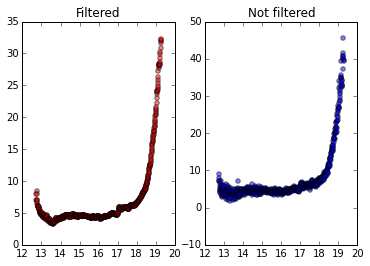

In [188]:
#Plot code before and after filtering
plt.subplot(1,2,1)
plt.title("Filtered")
plt.scatter(dfarc.TIME/3600,alfa*(dfarc.HATCHCODE2-dfarc.HATCHCODE1), c="r",alpha=.5)
plt.subplot(1,2,2)
plt.title("Not filtered")
plt.scatter(dfarc.TIME/3600,alfa*(dfarc.C2-dfarc.C1), c="b",alpha=.5)

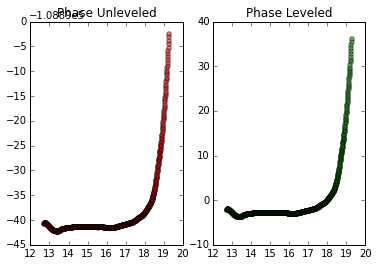

In [164]:
#Plot code before and after filtering
plt.subplot(1,2,1)
plt.title("Phase Unleveled")
plt.scatter(dfarc.TIME/3600,alfa*(dfarc.L1-dfarc.L2), c="r",alpha=.5)

plt.subplot(1,2,2)
plt.title("Phase Leveled")
plt.scatter(dfarc.TIME/3600,dfarc.PhaseDelay, c="g",alpha=.5)


In [192]:
print np.unique(df.PRN.values)

['GPS 1' 'GPS 10' 'GPS 11' 'GPS 13' 'GPS 14' 'GPS 15' 'GPS 16' 'GPS 17'
 'GPS 18' 'GPS 2' 'GPS 20' 'GPS 21' 'GPS 23' 'GPS 24' 'GPS 25' 'GPS 26'
 'GPS 27' 'GPS 28' 'GPS 29' 'GPS 3' 'GPS 30' 'GPS 31' 'GPS 4' 'GPS 5'
 'GPS 6' 'GPS 7' 'GPS 8' 'GPS 9']


In [191]:
print np.unique(df1sat.ARCS.values)

[ 1.]


In [168]:
print np.unique(dfarc.SUBARCS.values)

[ 11.]


In [190]:
np.unique(newdf.ARCS.values)

array([ 1.])

In [ ]:
print len(np.unique(new_dfarc1.SUBARCS.values))
np.unique(new_dfarc1.SUBARCS.values)

In [ ]:
subarc=0
print len(poly_outliers1[subarc])>0
print poly_outliers1
print outliers1

In [ ]:
print len(ptimes2) #un solo subarco
print ptimes2[0].size
print poly_outliers2[0].size

In [ ]:
print len(otimes1[0]) #un solo sub arco
print len(outliers1[0])

In [ ]:
plt.scatter(new_dfarc1.TIME[new_dfarc1.SUBARCS==17.],new_dfarc1.PhaseDelay[new_dfarc1.SUBARCS==17.])

In [ ]:
plt.scatter(new_dfarc1.TIME[new_dfarc1.SUBARCS==17.],new_dfarc1.POLYFIT[new_dfarc1.SUBARCS==17.])
print poly_outliers1
print poly_outliers2


In [ ]:
#/opt/anaconda/lib/python2.7/ #python con selenium
#/opt/anaconda/lib/python2.7/site-packages/ python modulos de anaconcda